<a href="https://colab.research.google.com/github/Vinicius-S-Grilo/Portfolio/blob/main/MVP_Sprint_III.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MVP Sprint III**
Vinicius Simas Grilo

Tema: Análise de dados do Spotify

**Seleção de dados**

No Kaggle achei interessante trabalhar com um dataset do Spotify. O link de acesso para o dataset utilizado no MVP segue: https://www.kaggle.com/datasets/dhruvildave/spotify-charts?select=charts.csv.
Gosto muito de música e me pareceu interessante e divertido aprender e treinar os conceitos utilizando dados sobre um hobby.

Sobre o dataset, se trata de um arquivo csv contendo dados de duas categorias dos charts do Spotify, os "top200" e "viral50". É composto de 9 colunas e 60954549 linhas.

Os dados são de diversos países reunindo informações do começo 2017 até final de 2021.


**Catálogo de dados**

Os 9 atributos estão divididos conforme o o catálogo de dados a seguir:

|Atributo|Descrição|Tipo|Valor Mínimo|Valor Máximo|
|---|---|---|---|---|
|title|título da música|string|-|-|
|rank|rank da música considerando a categoria do atributo chart ("top200" ou "viral50")|int|1|200|
|date|data no formato YYYY-MM-DD|date|2017-01-01|2021-12-30|
|artist|nome do(s) artista(s) que cantam a música|string|-|-|
|url|link para a música no spotify|string|-|-|
|region|nome do país do qual foi extraída a informação|string|-|-|
|chart|categoria do spotify de onde foram extraído os dados|string|top200|viral50|
|trend|tendência da música comparando os anos, se subiu (MOVE_UP), desceu (MOVE_DOWN) ou manteve a posição (SAME_POSITION)|string|MOVE_DOWN|SAME_POSITION|
|streams|quantidade de streams da música|int|1001|19749704|



**Objetivos específicos**

1.	Descobrir os top 1 artista mais ouvidos do ano, de cada país.
2.	Descobrir a música mais ouvida de cada país por ano.
3.	Relacionar artistas do público que ouve um tipo de música com outros artistas. Por exemplo, quem ouve rock também ouve pagode?
4.	Descobrir qual país com a maior quantidade de streams por ano.
5.	Comparar a quantidade de streams por ano.
6.	Comparar o % de streams de cada país com o total de streams do ano. Ou seja, qual parcela do total de streams cada país possui.
7.	Construir um dashboard no Power BI Desktop como alternativa para visualização dos dados.


**Seleção do ambiente em nuvem**

O ambiente escolhido para a execução do trabalho foi o Azure da Microsoft. Meu interesse em particular foi que além de eu achar ligeiramente mais user friendly (especialmente para quem não está habituado com trabalhar na nuvem), é a plataforma usada pela empresa onde trabalho. Então para mim é interessante aprender um pouco mais sobre como usar algumas das ferramentas disponíveis.

**Preparo dos dados e ETL na nuvem**

A primeira etapa executada foi baixar o arquivo csv em um disco local. Em seguida foi criada uma conta na Azure, criado um container de nome mvpgrilo para fazer o upload do arquivo csv no ambiente da nuvem.

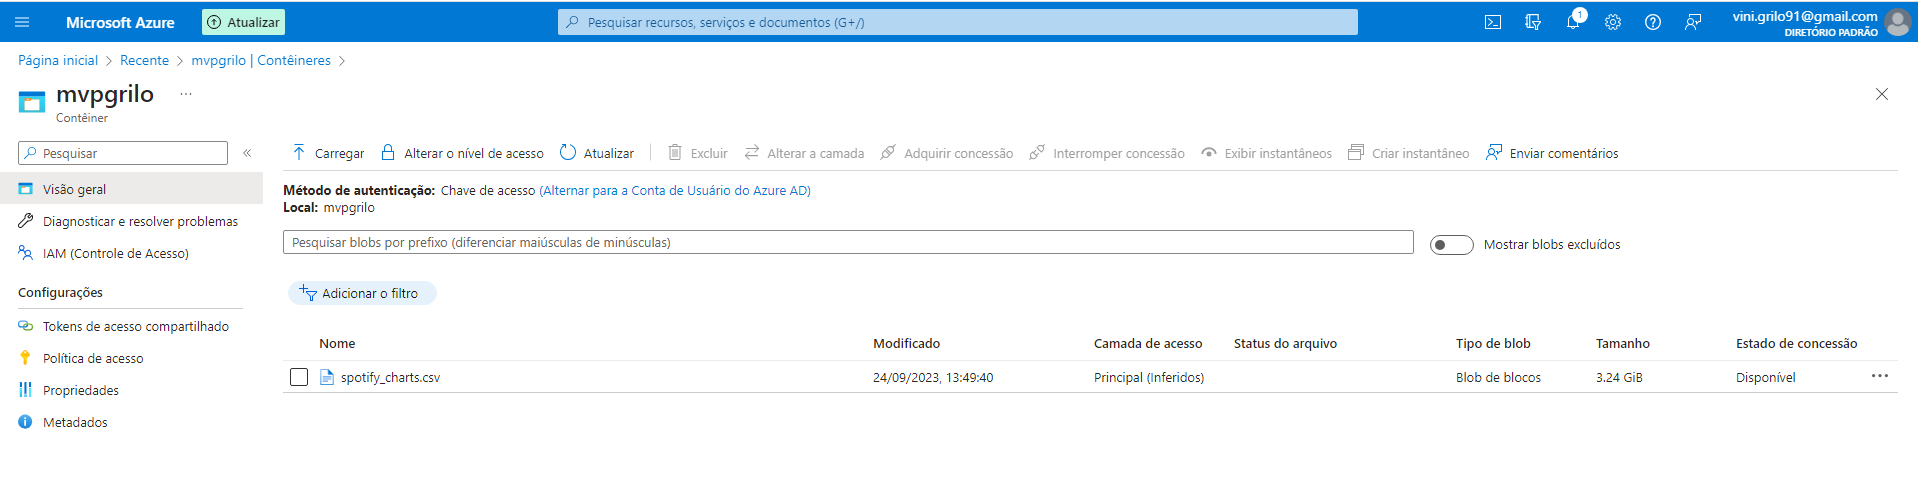




Em seguida prosegui para a criação de um SQL database para destinar os dados após o tratamento na ferramenta Data Factory. Todos os recursos da Azure utilizados pro ETL seguem na figura abaixo:

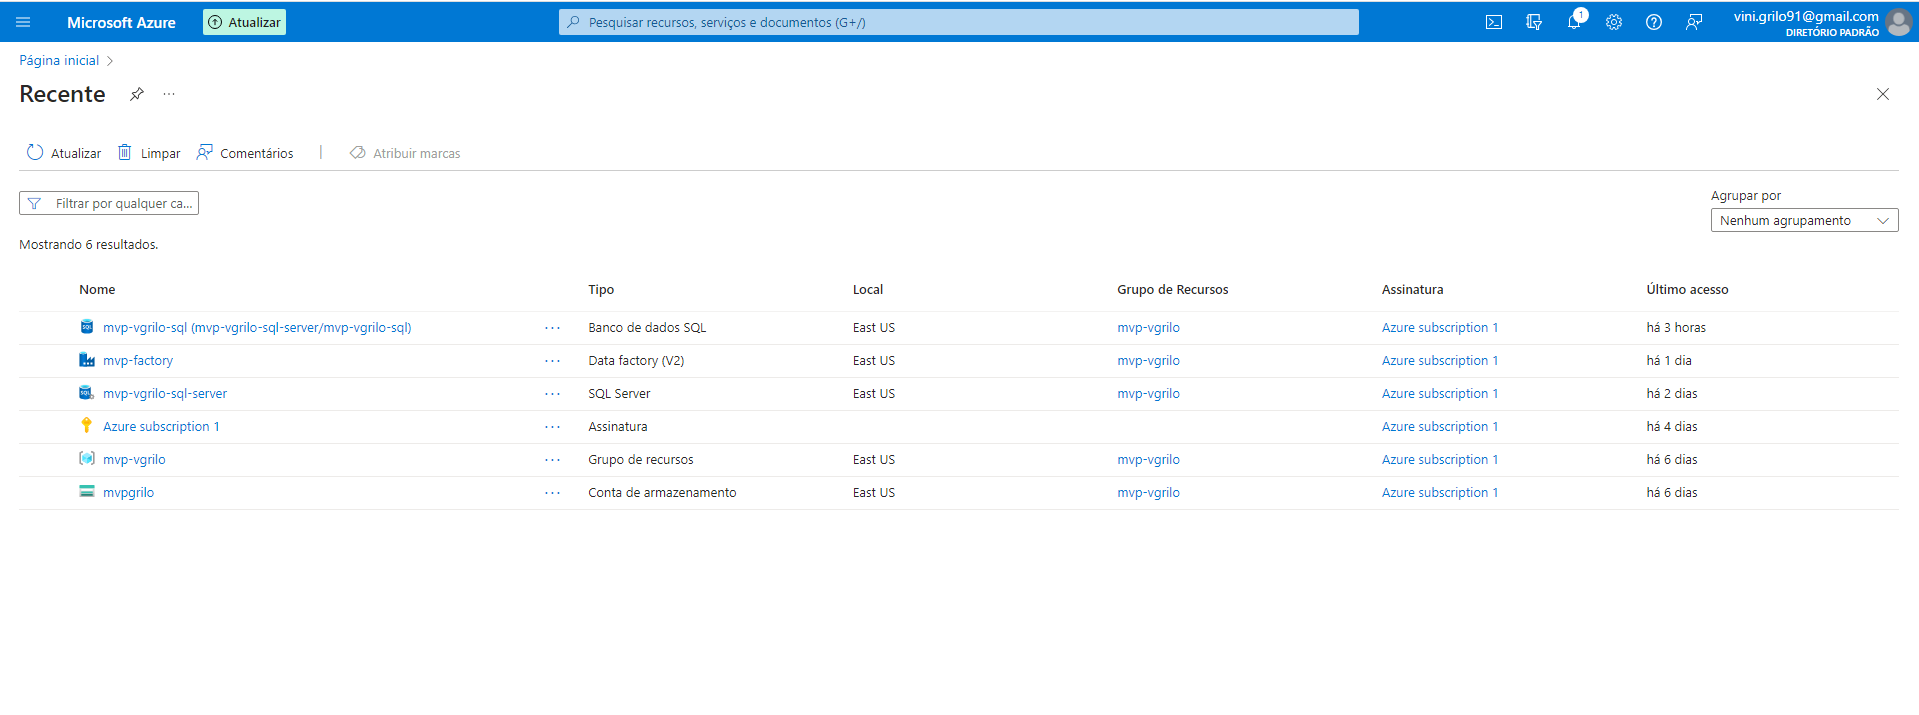

Já dentro do Data Factory, para construir um pipeline primeiro foi definido um data flow, onde neste foi importado o dataset disponível no container como fonte de dados e em cima deste foram feitas algumas operações de extração, transformação e carga, conforme o esquema a seguir:

# 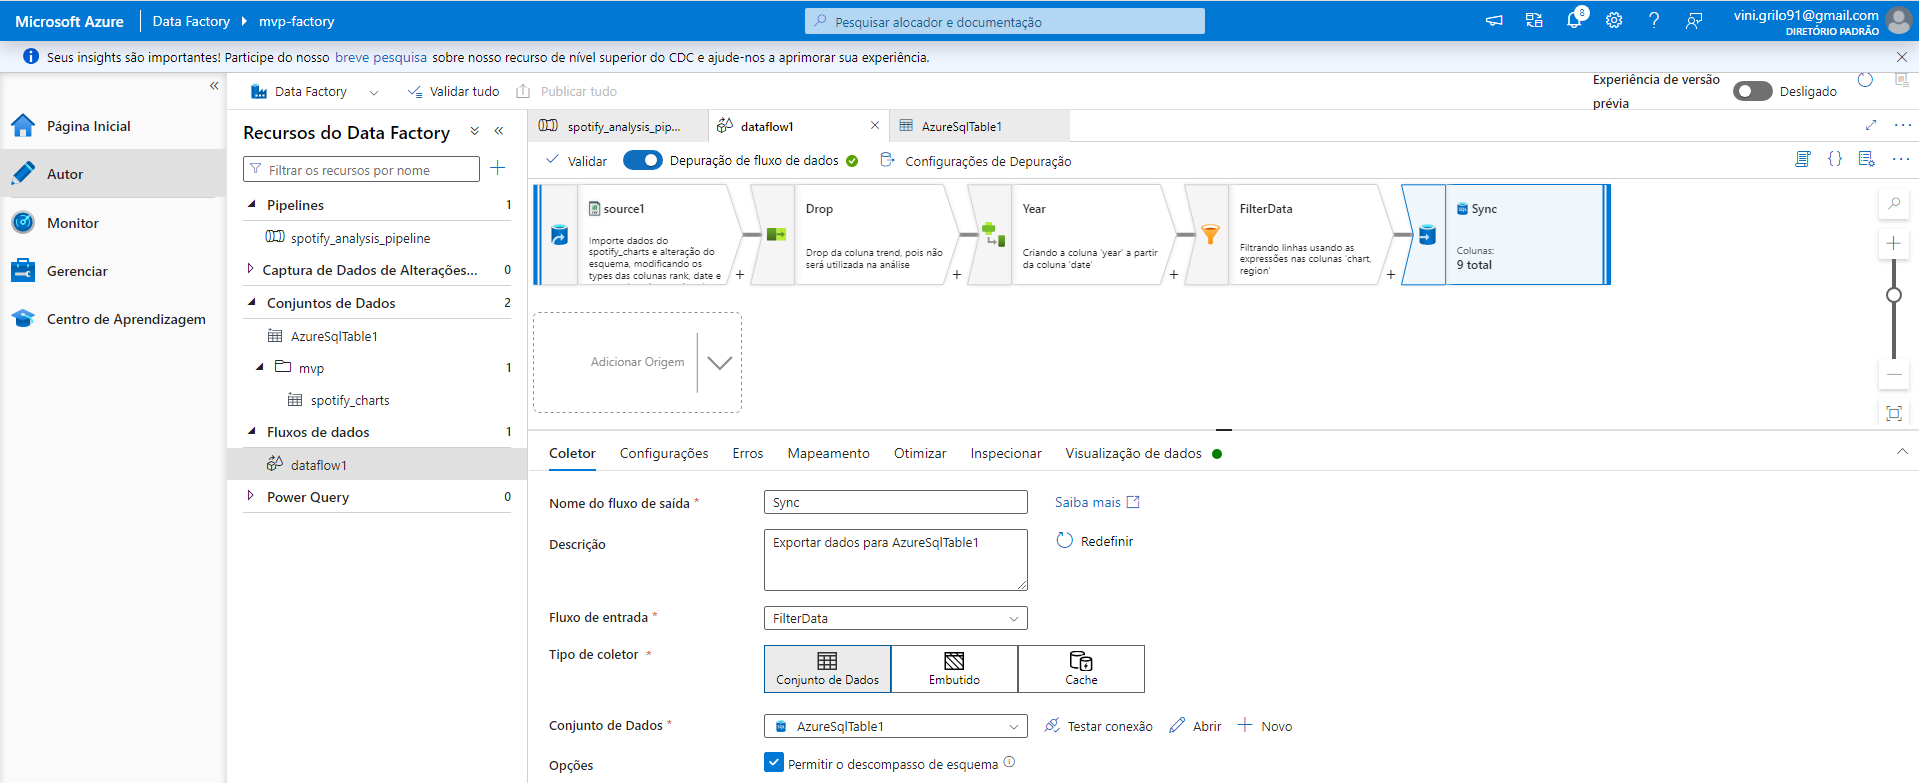

**source1** -> representa o input, minha fonte de dados do container.

**Drop** -> com este operador, ocorre a remoção da coluna trend, que não será utilizada para nenhuma das análises neste estudo.

**Year** -> refere-se a um operador de coluna calculada, onde o ano é obtido da coluna date, para facilitar consultas por ano mais a frente.

**FilterData** -> por se tratar de um dataset muito grande, foi feito um filtro de dados na coluna region para todos os países da América do Sul no dataset mais os Estados Unidos. Também há um filtro para a coluna chart, para que sejam trabalhados apenas com dados pertencentes à categoria "top200".

**Sync** -> refere-se à carga dos dados resultantes ao SQL database criado.

Uma vez desenhadas as operações, é efetuada a validação e se nenhum erro for verificado, são então publicadas todas as alterações no data flow. Então é ativada a depuração do fluxo de dados e criado um pipeline, ao qual é relacionado e data flow já definido

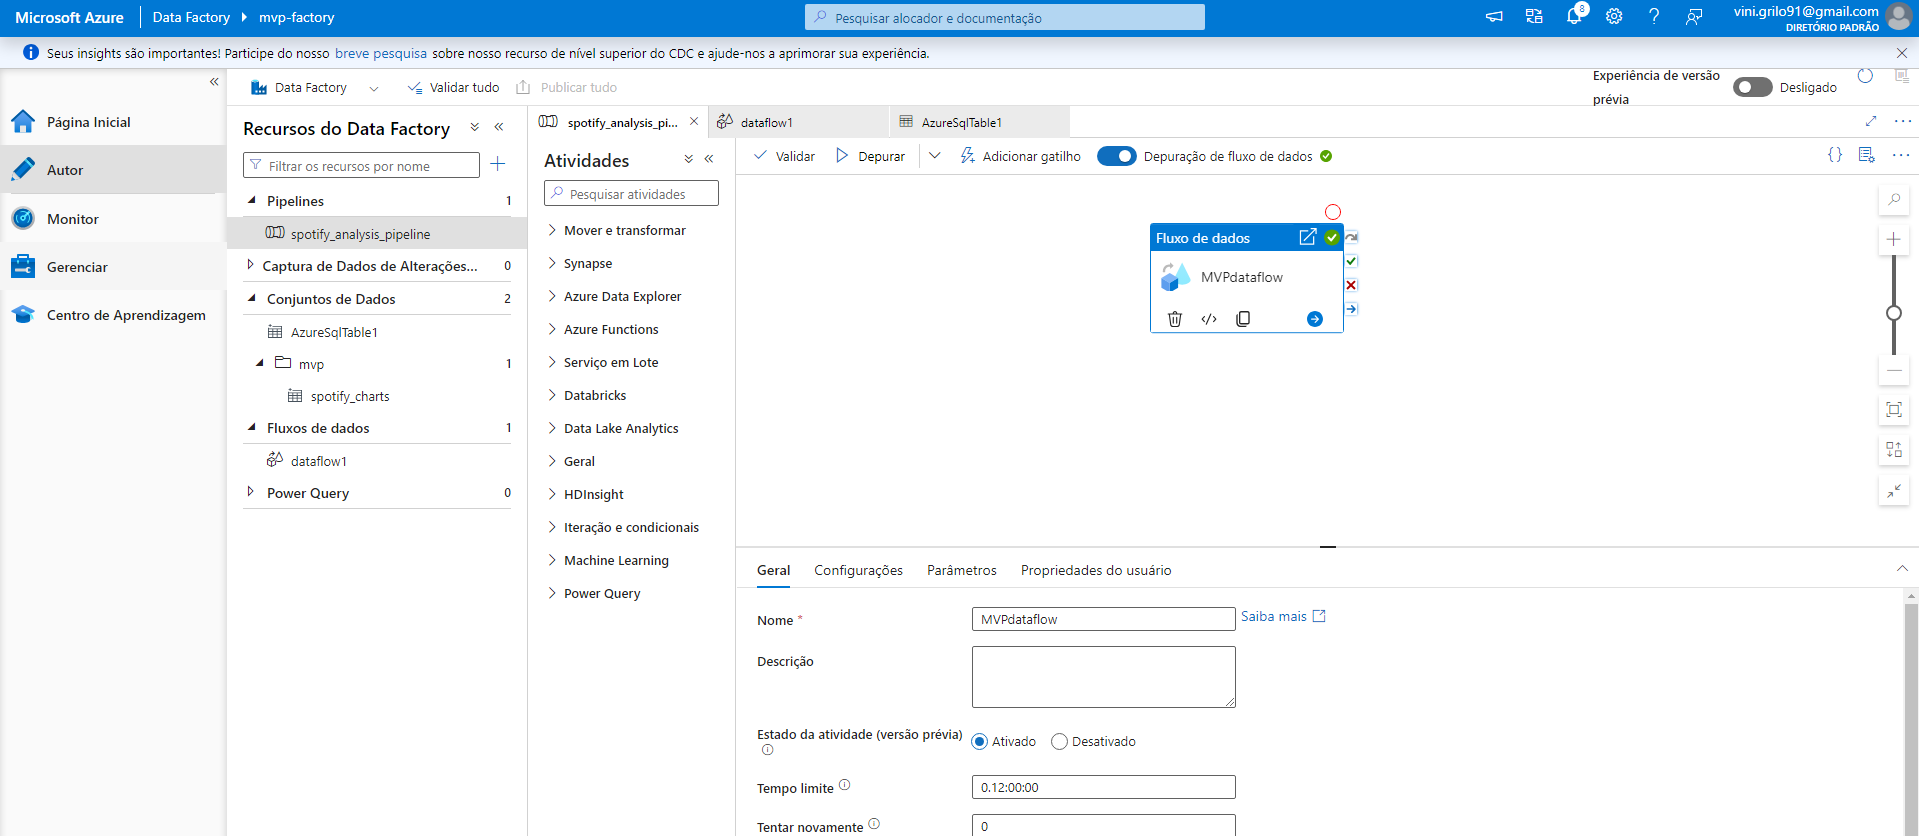

Após a criação do pipeline e associação do data flow à ele, basta publicar as modificações, validar e se nenhum erro for detectado ativar a depuração de fluxo de dados e depurar para executar o pipeline.

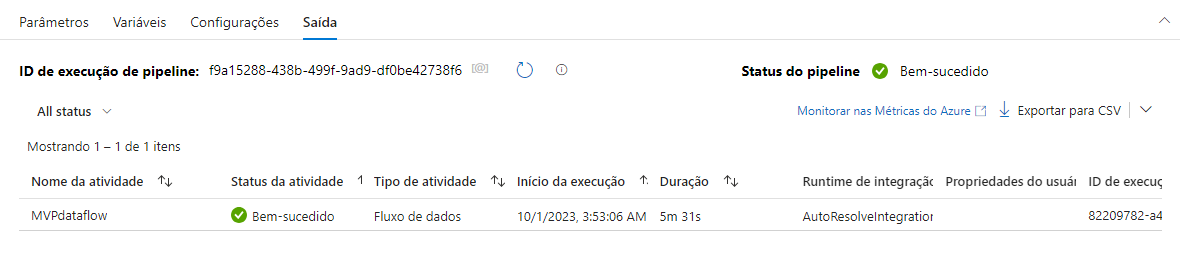


Caso nenhum erro ou falha durante a execução ocorra, o status de bem-sucedido ira aparecer conforme a imagem acima. E com isso, os dados tratados já estão carregados no SQL database e prontos para serem acessados para serem feitas as consultas desejadas.

Para executar as consultas em SQL, será utilizado o software Azure Data Studio, executado em máquina local, fora do ambiente de nuvem. A conexão do software com o SQL database e a execução de consultas funcionando podem ser observadas nas imagens abaixo:

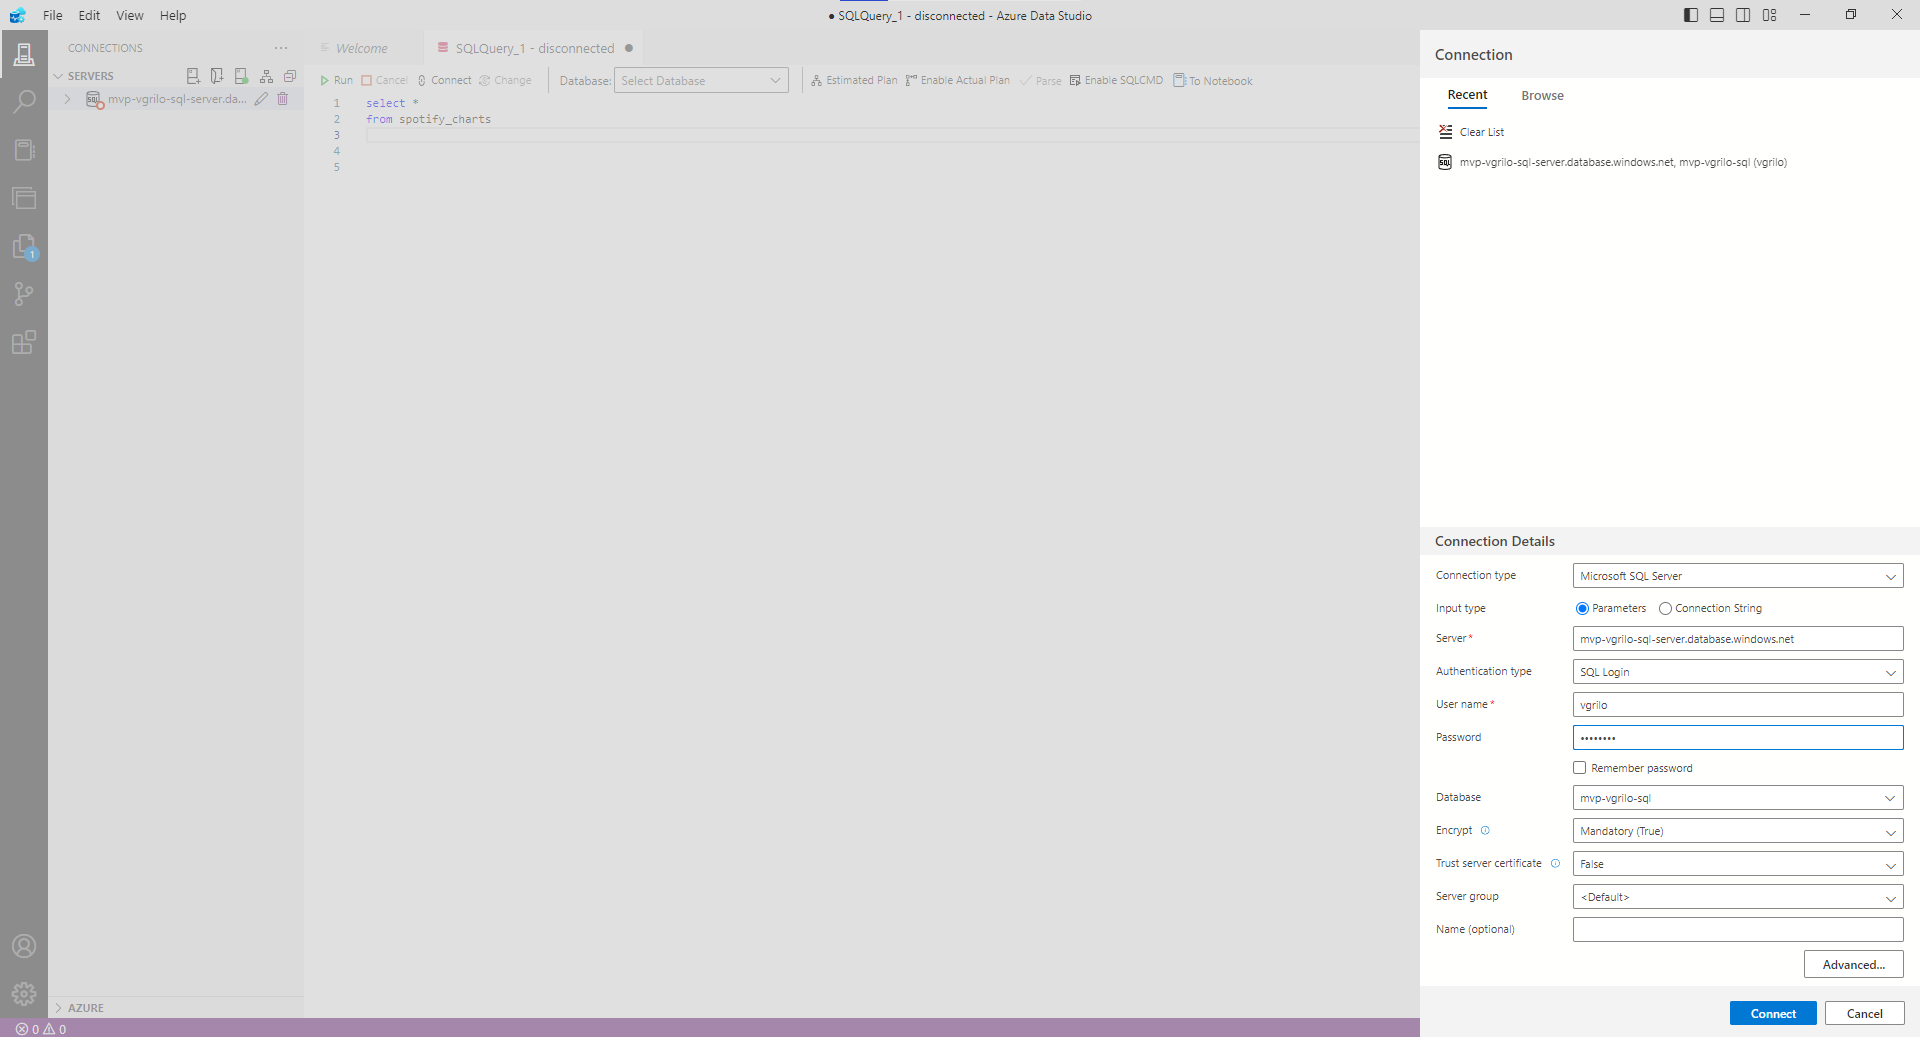

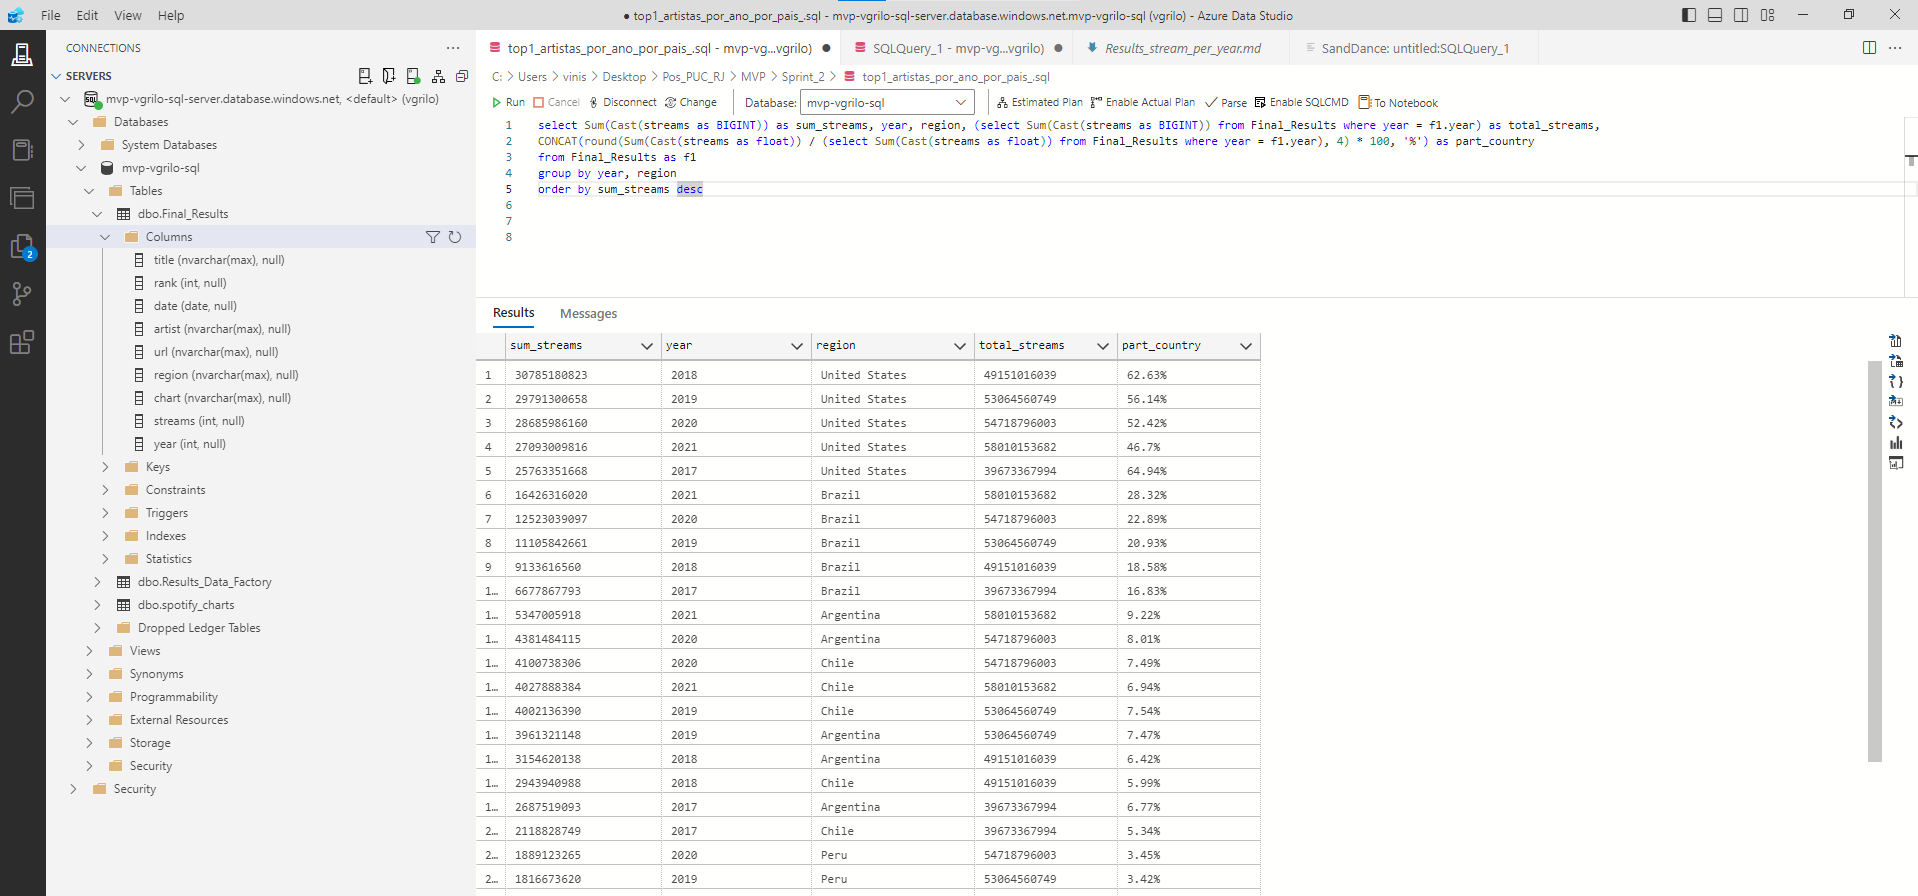

**Qualidade dos dados**

Os dados disponíveis no database resultantes do tratamento apresentam boa qualidade em termos de tipo e conforme visto abaixo, nenhum dos atributos possuem valores nulos.

```
SELECT
  Count(CASE WHEN artist IS NULL THEN 1 ELSE NULL END) AS artist_null_count,
  Count(CASE WHEN title IS NULL THEN 1 ELSE NULL END) AS title_null_count,
  Count(CASE WHEN streams IS NULL THEN 1 ELSE NULL END) AS streams_null_count,
  Count(CASE WHEN date IS NULL THEN 1 ELSE NULL END) AS year_null_count,
  Count(CASE WHEN rank IS NULL THEN 1 ELSE NULL END) AS rank_null_count,
  Count(CASE WHEN region IS NULL THEN 1 ELSE NULL END) AS region_null_count,
  Count(CASE WHEN url IS NULL THEN 1 ELSE NULL END) AS url_null_count,
  Count(CASE WHEN chart IS NULL THEN 1 ELSE NULL END) AS chart_null_count,
  Count(CASE WHEN year IS NULL THEN 1 ELSE NULL END) AS year_null_count
FROM
  Final_Results;
```



|artist_null_count|title_null_count|streams_null_count|year_null_count|rank_null_count|region_null_count|url_null_count|chart_null_count|year_null_count|
|---|---|---|---|---|---|---|---|---|
|0|0|0|0|0|0|0|0|0|


Dessa forma, nenhum tratamento adicional como preenchimento de valores nulos precisou ser efetuado. Então, iniciou-se a análise na tentativa de responder os objetivos listados no começo do projeto.

**Solução do problema**

**1 -  Descobrir os top 1 artistas mais ouvidos por ano e por país**

Ao executar a consulta abaixo, é usada uma *Common table expression* (CTE), onde nesta é criado o ranking por ano e país baseados e ordenados pela soma de streams. E então, desse resultado temporário é selecionado o ano, país, artista e a soma de streams totais, cujo o ranking foi 1, ou seja, o artista com o maior somatório de streams daquele ano pra um determinado país.

```
WITH RankedArtists AS (
  SELECT
    year,
    region,
    artist,
    SUM(streams) AS total_streams,
    ROW_NUMBER() OVER(PARTITION BY year, region ORDER BY SUM(streams) DESC) AS ranking
  FROM Final_Results
   
  GROUP BY
    year,
    region,
    artist
)
SELECT
  year,
  region,
  artist,
  total_streams
FROM
  RankedArtists
WHERE
  ranking = 1

```
O resultado da consulta pode ser observado na tabela abaixo:


|year|region|artist|total_streams|
|:---:|:---:|:---:|:---:|
|2017|Argentina|Ozuna|107105891|
|2017|Bolivia|Piso 21|3154441|
|2017|Brazil|Matheus &amp; Kauan|249835775|
|2017|Chile|Ozuna|76630519|
|2017|Colombia|Ed Sheeran|27244046|
|2017|Ecuador|Ed Sheeran|10208253|
|2017|Paraguay|Ozuna|7173748|
|2017|Peru|Ozuna|31715034|
|2017|United States|Kendrick Lamar|1132834065|
|2018|Argentina|Paulo Londra|104153731|
|2018|Bolivia|Piso 21|5119909|
|2018|Brazil|Z&#233; Neto &amp; Cristiano|512854206|
|2018|Chile|Ozuna|95097660|
|2018|Colombia|Ozuna|28143543|
|2018|Ecuador|Maluma|9904902|
|2018|Paraguay|Ozuna|8061948|
|2018|Peru|Maluma|37576488|
|2018|United States|Post Malone|1931113925|
|2019|Argentina|Paulo Londra|224215917|
|2019|Bolivia|Paulo Londra|8434747|
|2019|Brazil|Mar&#237;lia Mendon&#231;a|699548604|
|2019|Chile|Bad Bunny|146549804|
|2019|Colombia|J Balvin, Bad Bunny|26933083|
|2019|Ecuador|Paulo Londra|19309662|
|2019|Paraguay|Paulo Londra|17814303|
|2019|Peru|Paulo Londra|58929939|
|2019|United States|Post Malone|1690389416|
|2020|Argentina|J Balvin|114299123|
|2020|Bolivia|Bad Bunny|13816064|
|2020|Brazil|Henrique &amp; Juliano|512472077|
|2020|Chile|Bad Bunny|291329455|
|2020|Colombia|J Balvin|88638045|
|2020|Ecuador|Bad Bunny|44352512|
|2020|Paraguay|Bad Bunny|35490094|
|2020|Peru|Bad Bunny|77745474|
|2020|United States|Juice WRLD|1738954501|
|2021|Argentina|Rauw Alejandro|129957293|
|2021|Bolivia|Bad Bunny|14467232|
|2021|Brazil|Gusttavo Lima|470306099|
|2021|Chile|Bad Bunny|208628541|
|2021|Colombia|Bad Bunny|73927748|
|2021|Ecuador|Bad Bunny|46654297|
|2021|Paraguay|Bad Bunny|32877888|
|2021|Peru|Bad Bunny|64195943|
|2021|United States|Olivia Rodrigo|1571241675|


Para todos os anos e países acima listados, é verificado que apesar de uma grande variedade de artistas entre os países, com o passar dos anos com exceção do Brasil, quase todos os países da América do Sul tendem a convergir em artista mais ouvido.

Também é possível observar que não só os Estados Unidos possuem um número muito maior de streams que todos os países da América do Sul juntos. Mais a frente, voltarei a explorar essa informação de uma outra forma.

**2 - Descobrir a música mais ouvida de cada país por ano**


Como uma análise complementar e de modo análogo à consulta anterior, também foi criada uma CTE mas dessa vez ao invés de ranquear pelo maior somatório de streams, foi selecionado a música com o maior número de streams de cada país em um determinado ano.

```
WITH RankedSong AS (
  SELECT
    year,
    region,
    artist,
    title,
    MAX(streams) AS MAX_streams,
    ROW_NUMBER() OVER(PARTITION BY year, region ORDER BY max(streams) DESC) AS ranking
  FROM Final_Results
   
  GROUP BY
    year,
    region,
    artist,
    title
)
SELECT
  year,
  region,
  artist,
  title,
  MAX_streams
FROM
  RankedSong
WHERE
  ranking = 1

```



Como resultado, obtemos a seguinte tabela:

|year|region|artist|title|MAX_streams|
|---|---|:---:|---|---|
|2017|Argentina|Luis Fonsi|Despacito (Featuring Daddy Yankee)|455217|
|2017|Bolivia|Luis Fonsi|Despacito (Featuring Daddy Yankee)|19530|
|2017|Brazil|Anitta, Mc Zaac, Maejor|Vai malandra (feat. Tropkillaz &amp; DJ Yuri Martins)|2001683|
|2017|Chile|Luis Fonsi|Despacito (Featuring Daddy Yankee)|304108|
|2017|Colombia|Luis Fonsi|Despacito (Featuring Daddy Yankee)|136855|
|2017|Ecuador|Luis Fonsi|Despacito (Featuring Daddy Yankee)|64238|
|2017|Paraguay|Luis Fonsi|Despacito (Featuring Daddy Yankee)|32255|
|2017|Peru|Luis Fonsi|Despacito (Featuring Daddy Yankee)|158383|
|2017|United States|Kendrick Lamar|HUMBLE.|4068152|
|2018|Argentina|Paulo Londra|Adan y Eva|485444|
|2018|Bolivia|Bad Bunny|MIA (feat. Drake)|24590|
|2018|Brazil|Anitta, Mc Zaac, Maejor|Vai malandra (feat. Tropkillaz &amp; DJ Yuri Martins)|1060057|
|2018|Chile|Paloma Mami|No Te Enamores|478711|
|2018|Colombia|Nicky Jam, J Balvin|X|131702|
|2018|Ecuador|Paulo Londra|Adan y Eva|56548|
|2018|Paraguay|Pedro Cap&#243;, Farruko|Calma - Remix|49947|
|2018|Peru|DJ Snake|Taki Taki (with Selena Gomez, Ozuna &amp; Cardi B)|174236|
|2018|United States|Drake|Nonstop|5749019|
|2019|Argentina|Sech, Darell|Otro Trago|515515|
|2019|Bolivia|KAROL G, Nicki Minaj|Tusa|37397|
|2019|Brazil|Tropkillaz, J Balvin, Anitta, Mc Zaac|Bola Rebola|1201313|
|2019|Chile|Paloma Mami|Fing&#237;as|816577|
|2019|Colombia|Anuel AA, Daddy Yankee, KAROL G, J Balvin, Ozuna|China|139894|
|2019|Ecuador|Sech, Darell|Otro Trago|82382|
|2019|Paraguay|Sech, Darell|Otro Trago|77678|
|2019|Peru|KAROL G, Nicki Minaj|Tusa|250943|
|2019|United States|Ariana Grande|7 rings|3961641|
|2020|Argentina|Maluma|Haw&#225;i|736568|
|2020|Bolivia|Bad Bunny, Jhay Cortez|D&#193;KITI|68209|
|2020|Brazil|Os Bar&#245;es Da Pisadinha|Recairei - Ao Vivo|1492654|
|2020|Chile|Bad Bunny, Jhay Cortez|D&#193;KITI|1181291|
|2020|Colombia|Bad Bunny, Jhay Cortez|D&#193;KITI|337877|
|2020|Ecuador|Bad Bunny, Jhay Cortez|D&#193;KITI|189595|
|2020|Paraguay|Bad Bunny, Jhay Cortez|D&#193;KITI|163781|
|2020|Peru|Bad Bunny, Jhay Cortez|D&#193;KITI|389612|
|2020|United States|Taylor Swift|the 1|4175284|
|2021|Argentina|Bizarrap, Nicky Jam|Nicky Jam: Bzrp Music Sessions, Vol. 41|858467|
|2021|Bolivia|Gera MX, Christian Nodal|Botella Tras Botella|81858|
|2021|Brazil|Israel &amp; Rodolffo|Batom de Cereja - Ao Vivo|1899844|
|2021|Chile|Bad Bunny|Yonaguni|857956|
|2021|Colombia|Feid|VACAXIONES|328848|
|2021|Ecuador|Bad Bunny|Yonaguni|146639|
|2021|Paraguay|Bad Bunny|Yonaguni|125162|
|2021|Peru|Rauw Alejandro|Todo De Ti|413544|
|2021|United States|Drake|Girls Want Girls (with Lil Baby)|6146233|

Com essa consulta, é interessante notar que as músicas mais ouvidas por ano por país entre os países da América do Sul tendem a ser os mesmos. Por exemplo, temos o ano de 2017 onde a música mais ouvida na América do Sul foi “Despacito”, com exceção do Brazil que foi “Vai malandra”. Também podemos ver em 2020 que a música mais ouvida foi DÁKITI de Bad Bunny e Jhay Cortez, agora com exceção do Brasil e Argentina com "Recairei – Ao Vivo" e "Hawái", respectivamente. E também, pode-se notar que os Estados Unidos distoam bastante do estilo musical da América Latina.

Fazendo uma pequena alteração no código, adicionando AND region = 'Brazil' à cláusula WHERE, temos exclusivamente os resultados do Brasil:

|year|region|artist|title|MAX_streams|
|---|---|---|---|---|
|2017|Brazil|Anitta, Mc Zaac, Maejor|Vai malandra (feat. Tropkillaz &amp; DJ Yuri Martins)|2001683|
|2018|Brazil|Anitta, Mc Zaac, Maejor|Vai malandra (feat. Tropkillaz &amp; DJ Yuri Martins)|1060057|
|2019|Brazil|Tropkillaz, J Balvin, Anitta, Mc Zaac|Bola Rebola|1201313|
|2020|Brazil|Os Bar&#245;es Da Pisadinha|Recairei - Ao Vivo|1492654|
|2021|Brazil|Israel &amp; Rodolffo|Batom de Cereja - Ao Vivo|1899844|

Por dois anos consecutivos (2017 e 2018), Anitta com "Vai malandra" assumiu o topo das paradas aqui no Brasil. Em 2019 Anitta ainda seguiu no topo com "Bola Rebola". Já em 2020, o funk cede lugar ao forró dos Barões da Pisadinha "Recairei" e em 2021 ao sertanejo "Batom de Cereja" de Isreal & Rodolffo.

Curiosamente ao adicionarmos a mesma condição nos artistas mais ouvidos por ano do Brasil, é possível notar que não há correlação nenhuma com as músicas com maior numero de streams:

|year|region|artist|total_streams|
|---|---|---|---|
|2017|Brazil|Matheus &amp; Kauan|249835775|
|2018|Brazil|Z&#233; Neto &amp; Cristiano|512854206|
|2019|Brazil|Mar&#237;lia Mendon&#231;a|699548604|
|2020|Brazil|Henrique &amp; Juliano|512472077|
|2021|Brazil|Gusttavo Lima|470306099|

Vemos que não só há uma predominância de cantores sertanejos como também nenhum dos artistas com mais streams são autores das músicas com maior quantidade de stream.

**3 - Relacionar artistas do público que ouve um tipo de música com outros artistas. Por exemplo, quem ouve rock também ouve pagode?**

Essa pergunta não pode ser respondida, pois para tal o dataset precisaria conter informações específicas de usuários únicos para poder mapear os estilos mais escutados por estes e então cruzar esses dados para saber se um quem ouve um estilo ouve também outro.

E indo além, com tal informação poderiam ser obtidos *insights* para criação ou otimização de algoritmos de recomendação de músicas para os usuários.

**4 - Descobrir qual país com a maior quantidade de streams por ano**

Com uma consulta relativamente mais simples que as feitas anteriormente, foi possível obter a quantidade total de streams por país por ano:



```
select region, Sum(Cast(streams as BIGINT)) as sum_streams, year
from Final_Results
group by year,region
order by sum_streams desc

```

|region|sum_streams|year|
|---|---|---|
|United States|30785180823|2018|
|United States|29791300658|2019|
|United States|28685986160|2020|
|United States|27093009816|2021|
|United States|25763351668|2017|
|Brazil|16426316020|2021|
|Brazil|12523039097|2020|
|Brazil|11105842661|2019|
|Brazil|9133616560|2018|
|Brazil|6677867793|2017|
|Argentina|5347005918|2021|
|Argentina|4381484115|2020|
|Chile|4100738306|2020|
|Chile|4027888384|2021|
|Chile|4002136390|2019|
|Argentina|3961321148|2019|
|Argentina|3154620138|2018|
|Chile|2943940988|2018|
|Argentina|2687519093|2017|
|Chile|2118828749|2017|
|Peru|1889123265|2020|
|Peru|1816673620|2019|
|Peru|1779313215|2021|
|Colombia|1594327510|2021|
|Colombia|1499964751|2020|
|Peru|1353831240|2018|
|Colombia|1173222112|2019|
|Peru|1047280275|2017|
|Colombia|965389042|2018|
|Colombia|813805950|2017|
|Ecuador|705896920|2020|
|Ecuador|695576481|2021|
|Paraguay|667025662|2021|
|Paraguay|617653378|2020|
|Ecuador|565831034|2019|
|Paraguay|411980464|2019|
|Ecuador|407573577|2018|
|Bolivia|379690676|2021|
|Bolivia|314910011|2020|
|Ecuador|309275981|2017|
|Paraguay|261078166|2018|
|Bolivia|236252662|2019|
|Paraguay|161118785|2017|
|Bolivia|145785505|2018|
|Bolivia|94319700|2017|




Da tabela acima, tem-se os países com maior número de streams total por ano em ordem decrescente de total da soma de streams.

Verifica-se ainda que os Estados Unidos possuem uma quantidade de streams muito maior que todos os países em questão, ocupando a primeira posição todos os anos, seguido do Brasil.

Isso pode ser graficamente observado no gráfico de barras abaixo, gerado pela extensão SandDance do Azure Data Studio:


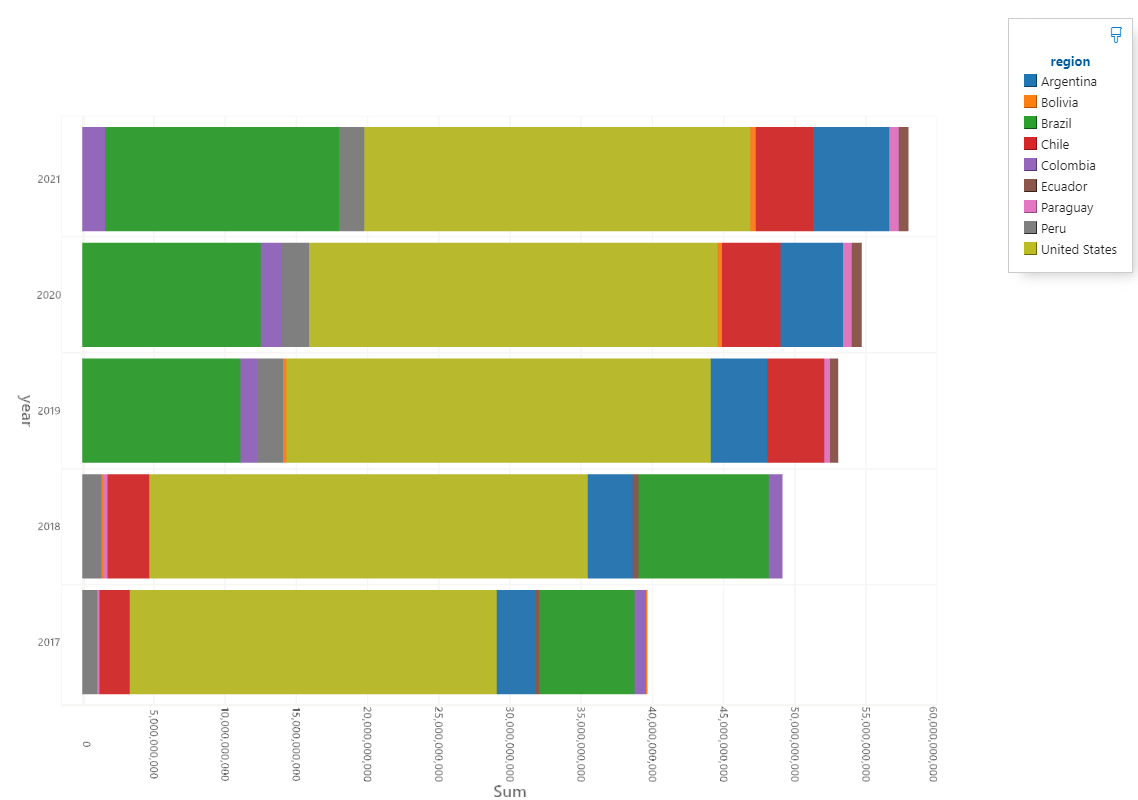

Outras informações podem ser obtidas deste gráfico, por exemplo, é possível verificar que o número total de streams aumentou de 2017 para 2021 e que mesmo aumentando, tanto os Estados Unidos quanto o Brasil mantiveram as maiores parcelas de streams.

**5 - Comparar a quantidade de streams por ano**

Essa pergunta já foi respondida na consulta feita no item 4, porém agora em uma visão holística, é possível mostrar o total de streams por ano, utilizando o seguinte código:

```
select Sum(Cast(streams as BIGINT)) as sum_streams, year
from Final_Results
group by year
order by sum_streams desc
```
Um detalhe dessa consulta é que o tipo da soma total de streams teve que ser alterado de int pra bigint pois estourou o limite máximo que o tipo int pode assumir. Segue abaixo a tabela com os resultados.

|sum_streams|year|
|---|---|
|58010153682|2021|
|54718796003|2020|
|53064560749|2019|
|49151016039|2018|
|39673367994|2017|


Desse modo, como já era esperado, a soma total de streams aumenta progressivamente ao longo dos anos, onde 2017 tem-se cerca de 39.67 bilhões de streams e 2021 temos 58 bilhões aproximadamente.




Abaixo uma visualisação gráfica montada na extensão SandDance do Azure Data Studio:


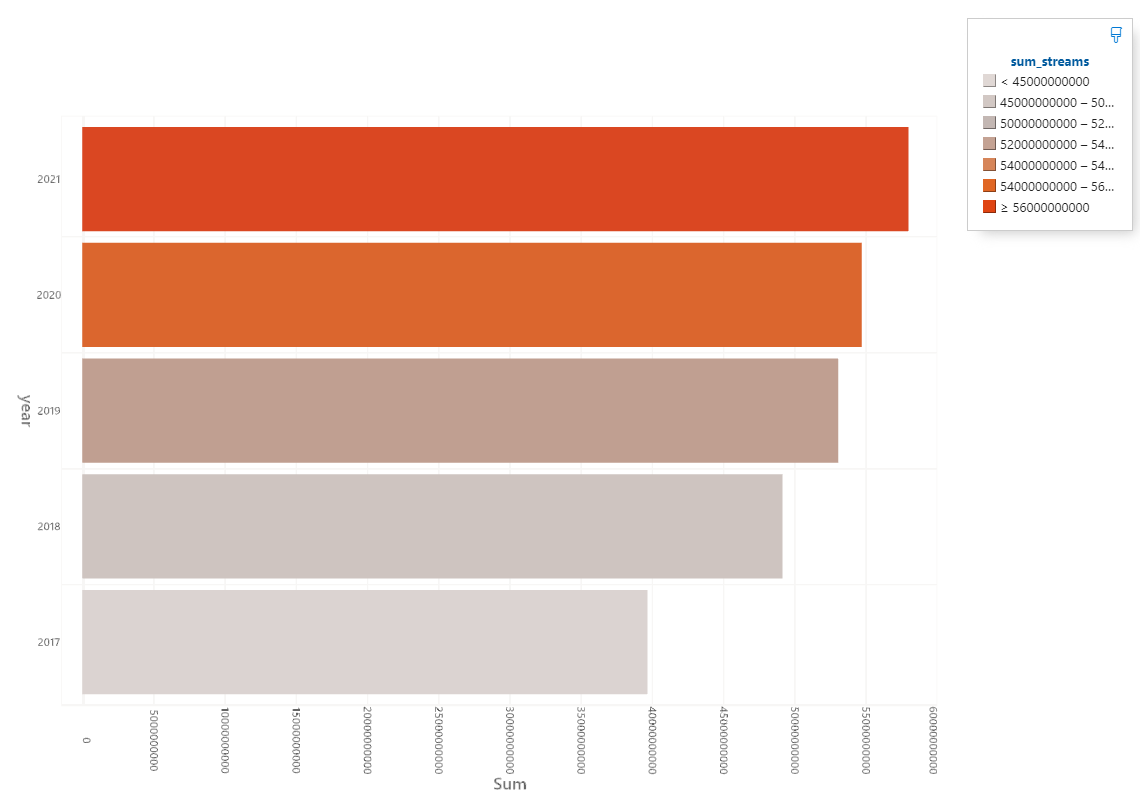

**6 - Comparar o % de streams de cada país com o total de streams do ano. Ou seja, qual parcela do total de streams cada país possui**

Como última consulta, temos essa análise de percentual total de streams que cada país representa em um determinado ano.

```
select Sum(Cast(streams as BIGINT)) as sum_streams, year, region, (select Sum(Cast(streams as BIGINT)) from Final_Results where year = f1.year) as total_streams,
CONCAT(round(Sum(Cast(streams as float)) / (select Sum(Cast(streams as float)) from Final_Results where year = f1.year), 4) * 100, '%') as part_country
from Final_Results as f1
group by year, region
order by sum_streams desc
```



|sum_streams|year|region|total_streams|part_country|
|---|---|---|---|---|
|30785180823|2018|United States|49151016039|62.63%|
|29791300658|2019|United States|53064560749|56.14%|
|28685986160|2020|United States|54718796003|52.42%|
|27093009816|2021|United States|58010153682|46.7%|
|25763351668|2017|United States|39673367994|64.94%|
|16426316020|2021|Brazil|58010153682|28.32%|
|12523039097|2020|Brazil|54718796003|22.89%|
|11105842661|2019|Brazil|53064560749|20.93%|
|9133616560|2018|Brazil|49151016039|18.58%|
|6677867793|2017|Brazil|39673367994|16.83%|
|5347005918|2021|Argentina|58010153682|9.22%|
|4381484115|2020|Argentina|54718796003|8.01%|
|4100738306|2020|Chile|54718796003|7.49%|
|4027888384|2021|Chile|58010153682|6.94%|
|4002136390|2019|Chile|53064560749|7.54%|
|3961321148|2019|Argentina|53064560749|7.47%|
|3154620138|2018|Argentina|49151016039|6.42%|
|2943940988|2018|Chile|49151016039|5.99%|
|2687519093|2017|Argentina|39673367994|6.77%|
|2118828749|2017|Chile|39673367994|5.34%|
|1889123265|2020|Peru|54718796003|3.45%|
|1816673620|2019|Peru|53064560749|3.42%|
|1779313215|2021|Peru|58010153682|3.07%|
|1594327510|2021|Colombia|58010153682|2.75%|
|1499964751|2020|Colombia|54718796003|2.74%|
|1353831240|2018|Peru|49151016039|2.75%|
|1173222112|2019|Colombia|53064560749|2.21%|
|1047280275|2017|Peru|39673367994|2.64%|
|965389042|2018|Colombia|49151016039|1.96%|
|813805950|2017|Colombia|39673367994|2.05%|
|705896920|2020|Ecuador|54718796003|1.29%|
|695576481|2021|Ecuador|58010153682|1.2%|
|667025662|2021|Paraguay|58010153682|1.15%|
|617653378|2020|Paraguay|54718796003|1.13%|
|565831034|2019|Ecuador|53064560749|1.07%|
|411980464|2019|Paraguay|53064560749|0.78%|
|407573577|2018|Ecuador|49151016039|0.83%|
|379690676|2021|Bolivia|58010153682|0.65%|
|314910011|2020|Bolivia|54718796003|0.58%|
|309275981|2017|Ecuador|39673367994|0.78%|
|261078166|2018|Paraguay|49151016039|0.53%|
|236252662|2019|Bolivia|53064560749|0.45%|
|161118785|2017|Paraguay|39673367994|0.41%|
|145785505|2018|Bolivia|49151016039|0.3%|
|94319700|2017|Bolivia|39673367994|0.24%|


Com essa consulta, um fato curioso vem à tona: quase todos os países da América do Sul apresentam uma tendência crescente com o passar dos anos, comportamento inversamente proporcional à participação total dos streams dos Estados Unidos. Este país, apesar de em números absolutos ainda apresentar o maior resultado de todos, mesmo aumento estes números absolutos, sua participação no total de streams vem caindo. Assim é possível concluir que a maior parte do aumento no total de streams se devem aos outros países da América do Sul que tiveram sua participação elevada ao longo dos anos em sua maioria dos casos.

**7 - Construir um dashboard no Power BI Desktop como alternativa para visualização dos dados**

Utilizando o Power BI Desktop, é possível construir dashboards interessantes com os dados utilizados no estudo.

Para isso primeiro conectei o Power BI ao mesmo SQL database e puxei a tabela de dados Final_Results, a mesma onde foram efetuadas as consultas SQL no Azure Data Studio.

Como resultado, foi gerado o dashboard a seguir:

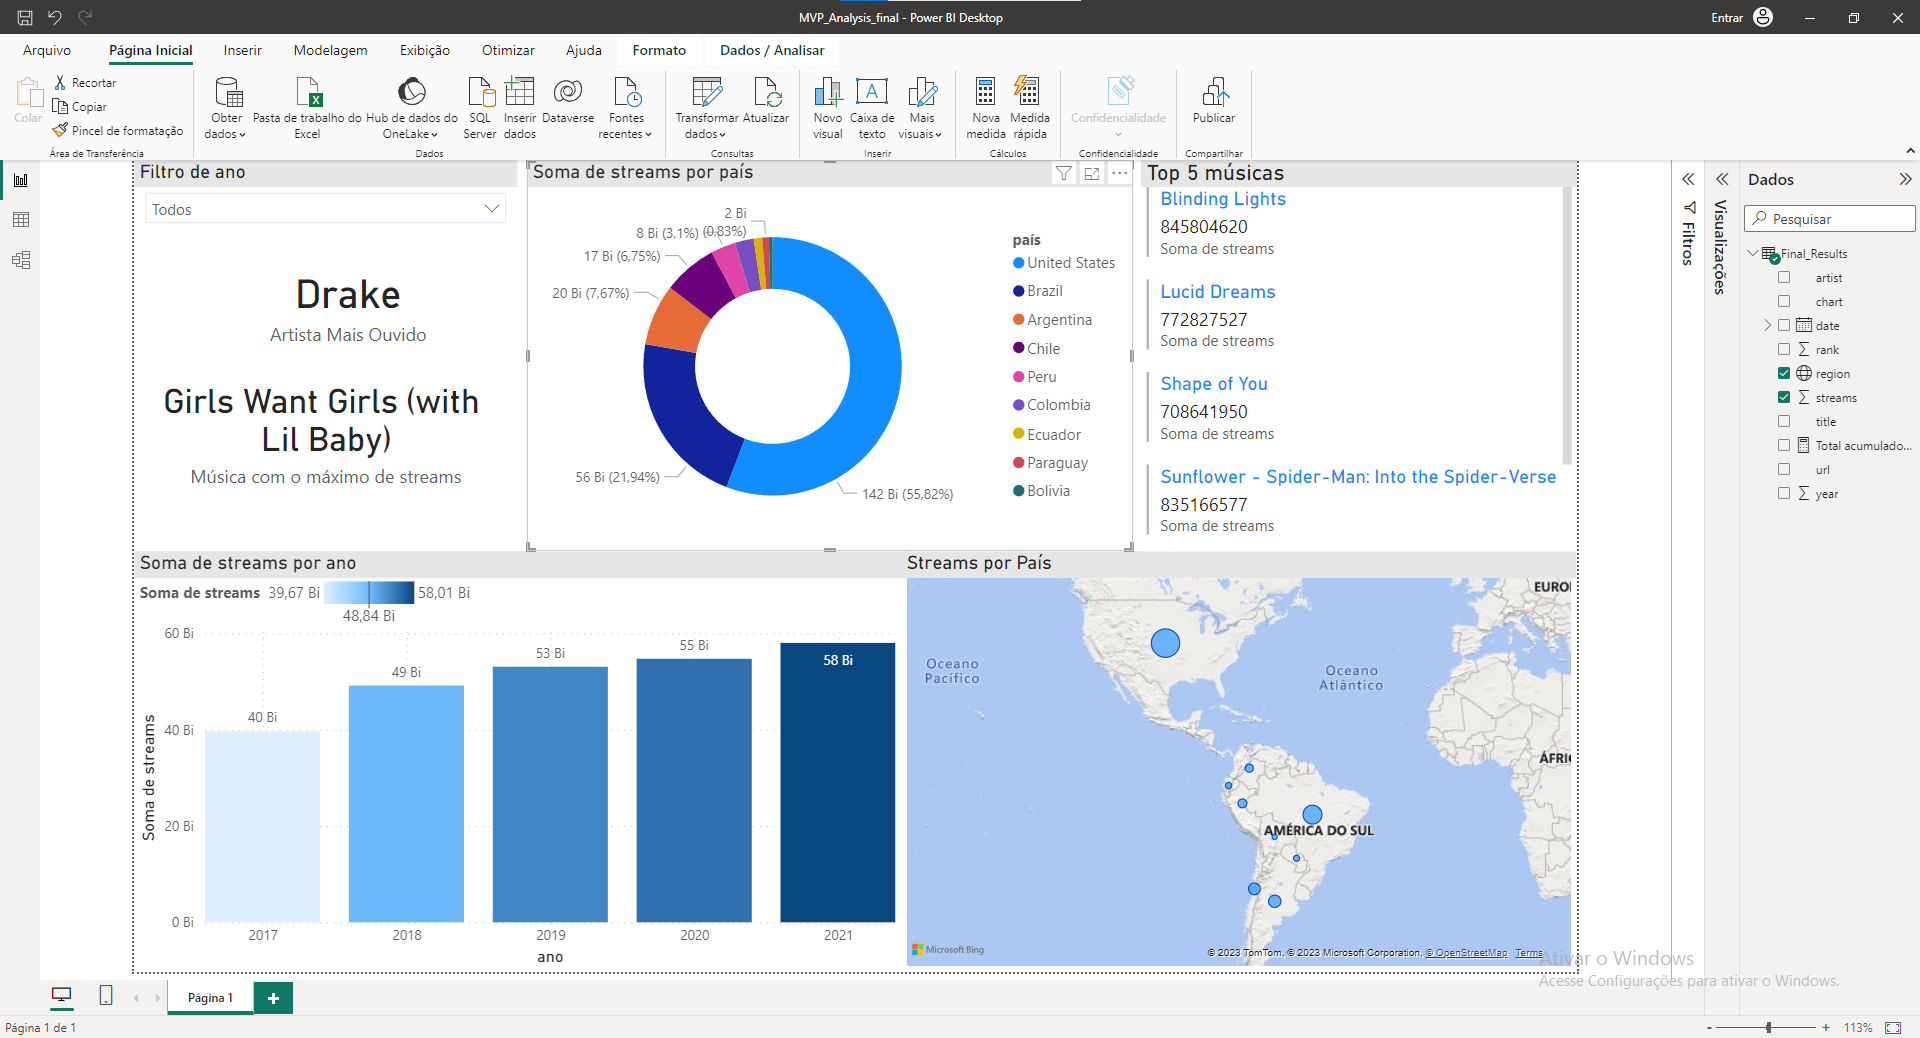

Ele é simples e dada sua interatividade permite obter informações de forma rápida e dinâmica. É composto de 7 visuais:

- Filtro de ano
- Cartão com o artista mais ouvido
- Cartão com música com o maior valor único de streams
- Gráfico barras da soma de streams por ano
- Mapa de soma de streams por país
- Gráfico de rosca da soma de streams por país
- Cartão de linha múltipla com as top 5 músicas por soma de streams

**Auto-avaliação**

Consegui efetuar todas as etapas solicitadas no MVP. Tentei priorizar a qualidade da escrita e a clareza nos pontos apresentados.

Dos sete objetivos propostos pra este trabalho, consegui responder seis e somente um não foi possível por conta do tipo de dado utilizado.

Foram realizadas diversas comparações interessantes mesmo com o dataset reduzido.

Como uma forma de aprimorar o trabalho, poderia ao invés de fazer um catálogo manual como foi feito, aprender a utilizar alguma ferramenta da Azure para isso.

Ainda para aprimorar, poderia buscar outros dados de spotify para correlacionar com este e tentar um estudo mais aprofundado como desenvolver um algoritmo que correlaciona a probabilidade de quem ouve um estilo de música também escutar um outro específico. Dessa forma otimizando ou criando algoritmos de recomendação de música para o usuário.

Confesso que me diverti aprendendo com a realização deste MVP. Porém, ainda há muito para aprender!